# Machine Learning - Assignment 1

Arne Huckemann, Elise Wolf

In [285]:
%matplotlib widget

In [286]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from mnist import MNIST  # run from Anaconda shell: pip install python-mnist
import sklearn
import sklearn.metrics
from sklearn.model_selection import KFold

# setup plotting 
from IPython import get_ipython
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")
def nextplot():
    if inTerminal:
        plt.clf()     # this clears the current plot
    else:
        plt.figure()  # this creates a new plot 

# Load the data

In [287]:
mndata = MNIST("data/")
X, y = mndata.load_training()
y = np.array(y, dtype="uint8")
X = np.array([np.array(x) for x in X], dtype="uint8")
N, D = X.shape
Xtest, ytest = mndata.load_testing()
ytest = np.array(ytest, dtype="uint8")
Xtest = np.array([np.array(x) for x in Xtest], dtype="uint8")
Ntest = Xtest.shape[0]

In [288]:
# Optional: use a smaller sample of the data
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y == c)[0], size=100, replace=False))
X_s = X[p, :]
y_s = y[p]
N_s = X_s.shape[0]
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(ytest == c)[0], size=10, replace=False))
Xtest_s = Xtest[p, :]
ytest_s = ytest[p]
Ntest_s = Xtest_s.shape[0]

In [289]:
def showdigit(x):
    "Show one digit as a gray-scale image."
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap="gray")

5


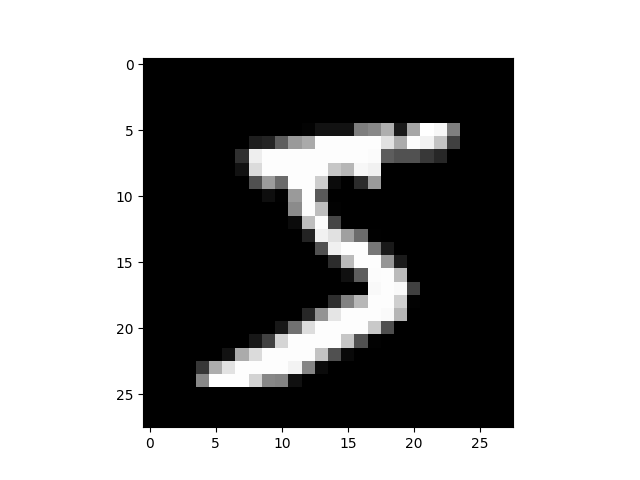

In [290]:
# Example: show first digit
nextplot()
showdigit(X[0,])
print(y[0])

In [291]:
def showdigits(X, y, max_digits=15):
    "Show up to max_digits random digits per class from X with class labels from y."
    num_cols = min(max_digits, max(np.bincount(y)))
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(
                10, num_cols, c * num_cols + j + 1, aspect="equal"
            )
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(
                    X[ii[j],].reshape(28, 28),
                    norm=mpl.colors.Normalize(0, 255),
                    cmap="gray",
                )
            else:
                ax.axis("off")

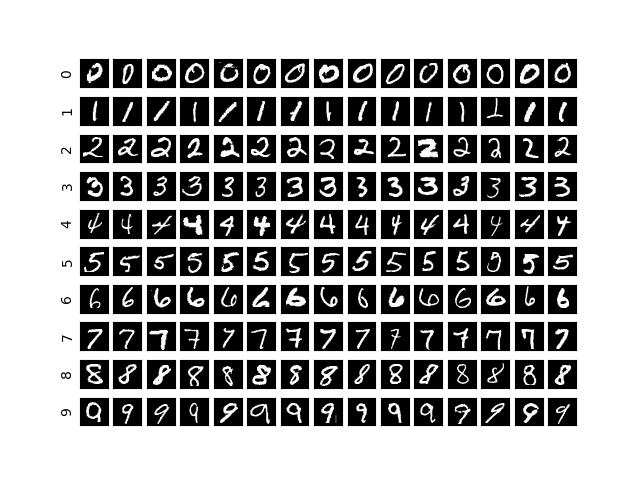

In [292]:
# Example: show 15 random digits per class from training data
nextplot()
showdigits(X, y)

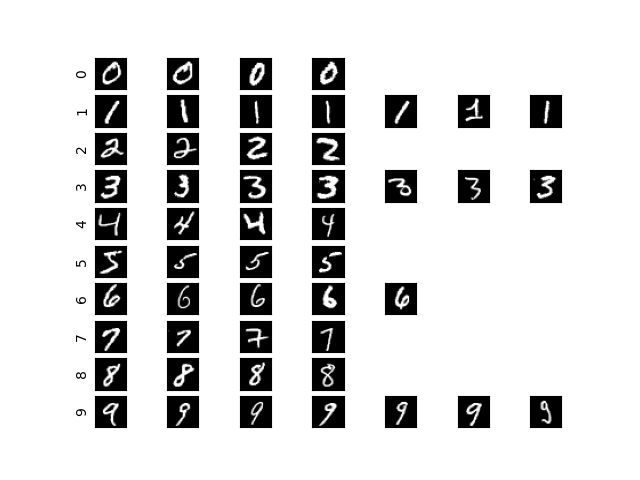

In [293]:
# Example: show a specific set of digits
nextplot()
showdigits(X[0:50,], y[0:50])

In [294]:
# A simple example dataset that you can use for testing
Xex = np.array([1, 0, 0, 1, 1, 1, 2, 0]).reshape(4, 2)
yex = np.array([0, 1, 2, 0])

# 1 Training

In [295]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

# calculate map estimate for the dirichlet prior (count class labels (frequency), fill into formular for fixed alpha)
def nb_train(X, y, alpha=1, K=None, C=None):
    """Train a Naive Bayes model.

    We assume that all features are encoded as integers and have the same domain
    (set of possible values) from 0:(K-1). Similarly, class labels have domain
    0:(C-1).

    Parameters
    ----------
    X : ndarray of shape (N,D)
        Design matrix.
    y : ndarray of shape (N,)
        Class labels.
    alpha : int
        Parameter for symmetric Dirichlet prior (Laplace smoothing) for all
        fitted distributions.
    K : int
        Each feature takes values in [0,K-1]. None means auto-detect.
    C : int
        Each class label takes values in [0,C-1]. None means auto-detect.

    Returns
    -------
    A dictionary with the following keys and values:

    logpriors : ndarray of shape (C,)
        Log prior probabilities of each class such that logpriors[c] contains
        the log prior probability of class c.

    logcls : ndarray of shape(C,D,K)
        A class-by-feature-by-value array of class-conditional log-likelihoods
        such that logcls[c,j,v] contains the conditional log-likelihood of value
        v in feature j given class c.
    """

    #return to metrices: vector for multinomial distribution of class labels, matrix: every feature is multinomial distributed, each column multinomial distributed 
    
    
    N, D = X.shape
    if K is None:
        K = int(np.max(X)) + 1 # hier int() angepasst, ursprünglich nur np.max, dann aber Error - Overflow. 
    if C is None:
        C = int(np.max(y)) + 1 # hier int( angepasst, ursprünglich nur np.max, dann aber Error - Overflow. 

    # calculate dirichlet prior for each class through counting class labels (frequency) and utilizing MAP estimate formula
    priors = np.zeros(C) # create empty array with 10 zeros
    for c in range(C):
        priors[c] = (np.sum(y == c) + alpha - 1) / (N + C*alpha - C)
    
    # test
    # print(f"Priors: {priors}")
    # print(np.sum(priors))
    
    # Compute class-conditional densities in a class x feature x value array and store them in cls. P(X | y = c) ( equal to likelihood, "how likely is picture x with pixel v1, ..., v784 to be in class c")
    cls = np.zeros((C, D, K))
    for c in range(C): # for each class
        X_c = X[y == c] # get all samples that belong to class c: y == c
        for j in range(D): # for each feature of the 28*28 = 784 features
            counts = np.bincount(X_c[:, j], minlength=K)  # Count occurrences of each value of gray scale in feature j
            cls[c, j, :] = (counts + alpha - 1) / (X_c.shape[0] + K * alpha - K) # calculate the class-conditional density

            # test
            # if c == 0 and j == 0:  # Beispiel für die erste Klasse und das erste Feature
                # print(f"Class {c}, Feature {j}, Class-conditional densities: {cls[c, j, :]}")
                # print(f"Counts for Class 0, Feature 0: {counts}")  # Hier counts aus der Schleife drucken

    # Output result
    return dict(logpriors=np.log(priors), logcls=np.log(cls))

nb_train(X, y, alpha = 1, K = None, C = None)
    

/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_37330/1909912479.py:77: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))


{'logpriors': array([-2.31550148, -2.18598795, -2.30960971, -2.28098669, -2.32927136,
        -2.40406426, -2.31634601, -2.25936597, -2.32773198, -2.31112142]),
 'logcls': array([[[  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         ...,
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf]],
 
        [[  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         ...,
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf]],
 
        [[  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         ...,
 

In [296]:
# Test your code (there should be a warning when you run this)
model = nb_train(Xex, yex, alpha=1)
model
# This should produce:
# {'logcls': array([[[       -inf, -0.69314718, -0.69314718],
#          [ 0.        ,        -inf,        -inf]],
#
#         [[ 0.        ,        -inf,        -inf],
#          [       -inf,  0.        ,        -inf]],
#
#         [[       -inf,  0.        ,        -inf],
#          [       -inf,  0.        ,        -inf]]]),
#  'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_37330/1909912479.py:77: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))


{'logpriors': array([-0.69314718, -1.38629436, -1.38629436]),
 'logcls': array([[[       -inf, -0.69314718, -0.69314718],
         [ 0.        ,        -inf,        -inf]],
 
        [[ 0.        ,        -inf,        -inf],
         [       -inf,  0.        ,        -inf]],
 
        [[       -inf,  0.        ,        -inf],
         [       -inf,  0.        ,        -inf]]])}

In [297]:
# Test your code (this time no warning)
model = nb_train(Xex, yex, alpha=2)  # here we use add-one smoothing
model
# This should produce:
# {'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
#          [-0.51082562, -1.60943791, -1.60943791]],
#
#         [[-0.69314718, -1.38629436, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]],
#
#         [[-1.38629436, -0.69314718, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]]]),
#  'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

{'logpriors': array([-0.84729786, -1.25276297, -1.25276297]),
 'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
         [-0.51082562, -1.60943791, -1.60943791]],
 
        [[-0.69314718, -1.38629436, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]],
 
        [[-1.38629436, -0.69314718, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]]])}

# 2 Prediction

In [298]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each column.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

In [299]:
def nb_predict(model, Xnew):
    """Predict using a Naive Bayes model.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    Xnew : nd_array of shape (Nnew,D)
        New data to predict.

    Returns
    -------
    A dictionary with the following keys and values:

    yhat : nd_array of shape (Nnew,)
        Predicted label for each new data point.

    logprob : nd_array of shape (Nnew,)
        Log-probability of the label predicted for each new data point.
    """
    logpriors = model["logpriors"]
    logcls = model["logcls"]
    Nnew = Xnew.shape[0]
    C, D, K = logcls.shape

    # Compute the unnormalized log joint probabilities P(Y=c, x_i) of each
    # test point (row i) and each class (column c); store in logjoint
    logjoint = np.zeros((Nnew, C))
    #yhat = np.zeros(Nnew, dtype="int")
    # YOUR CODE HERE

    # for all data points xi, for all classes c calculate the log joint probability
    for i in range(Nnew):  # for each data point
        for c in range(C):  # for each class
            logjoint[i, c] = logpriors[c] + np.sum(logcls[c, np.arange(D), Xnew[i, :]])

    # Compute the logsumexp across classes for each test point (for normalization)
    logsum = logsumexp(logjoint.T)  # Transpose to sum over classes (axis 0)

    # Predicted labels: Take the class with the highest log joint probability
    yhat = np.argmax(logjoint, axis=1)

    # Log-probability of the predicted label (log likelihood of the best class)
    logprob = logjoint[np.arange(Nnew), yhat] - logsum    
    
    return dict(yhat=yhat, logprob=logprob)

In [300]:
# Test your code
model = nb_train(Xex, yex, alpha=2)
nb_predict(model, Xex)
# This should produce:
# {'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486]),
#  'yhat': array([0, 1, 2, 0], dtype=int64)}

{'yhat': array([0, 1, 2, 0]),
 'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486])}

In [301]:
# Test your code on full MNIST data
model = nb_train(X, y, alpha=2)

nb_predict(model, Xtest)

{'yhat': array([7, 2, 1, ..., 4, 5, 6]),
 'logprob': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.37250519e-02, -7.91260391e-10,  0.00000000e+00])}

# 3 Experiments on MNIST Digits Data

In [302]:
# Let's train the model on the digits data and predict
model_nb2 = nb_train(X, y, alpha=2)
pred_nb2 = nb_predict(model_nb2, Xtest)
yhat = pred_nb2["yhat"]
logprob = pred_nb2["logprob"]

In [303]:
# Accuracy
sklearn.metrics.accuracy_score(ytest, yhat)

0.8363

Text(0.5, 0.98, 'Digits grouped by predicted label')

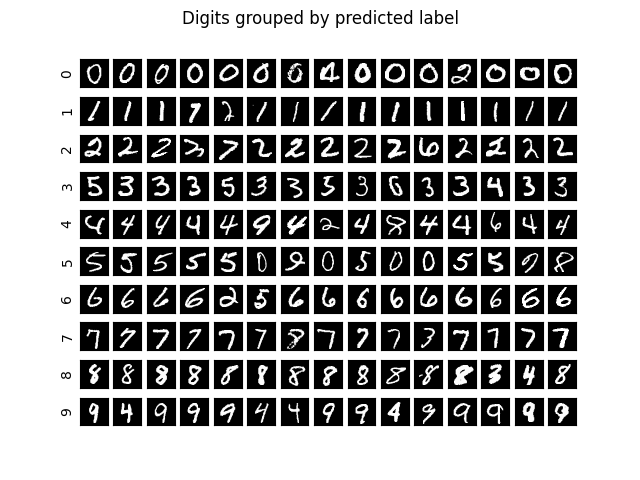

In [304]:
# show some digits grouped by prediction; can you spot errors?
nextplot()
showdigits(Xtest, yhat)
plt.suptitle("Digits grouped by predicted label")

prediction errors:
- 0 --> 4 or 2 but actually okay
- 1 --> 2
- 2 --> 3 that looks like 2, 7 that looks like 2, 6 ??
- 4 --> often mistaken as 5, once also 6 and 4
- 5 --> often mistaken as 0 (pretty often), once also 8 and 9 (why 8 and 9)
- 6 --> 5
- 7 --> 8 and 3
- 8 --> 3 and 4 (why 4)
- 9 -- often mistaken as 4, once also 8

Text(0.5, 0.98, 'Errors grouped by predicted label')

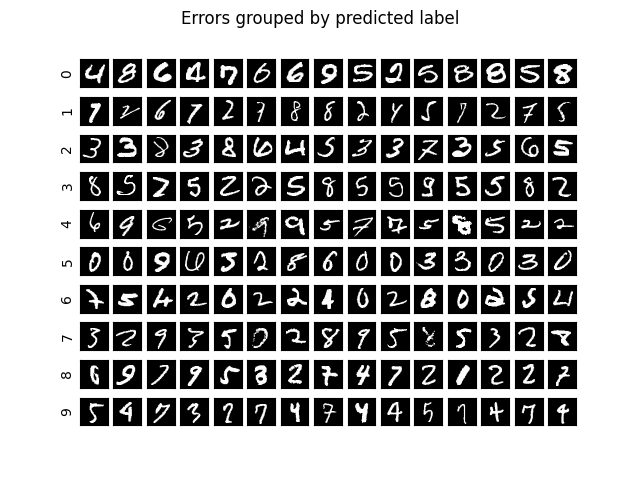

In [317]:
# do the same, but this time show wrong predicitions only
perror = ytest != yhat
nextplot()
showdigits(Xtest[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")

Text(0.5, 0.98, 'Errors grouped by predicted label')

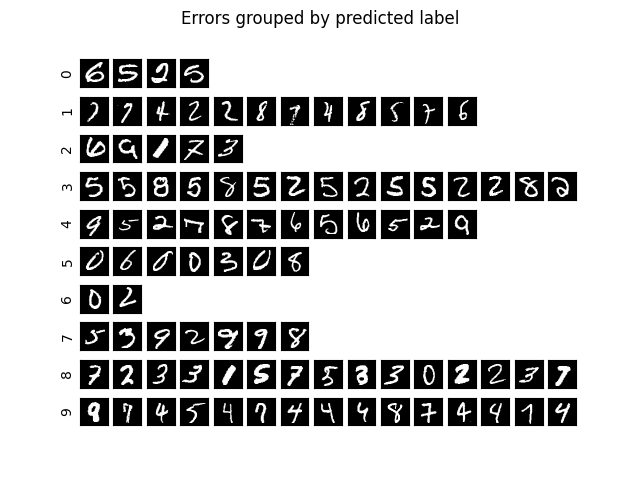

In [320]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
nextplot()
showdigits(Xtest[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")

Misclassification especially often for  1, 3, 4, 8 and 9, where
- 9 is mistaken as 4, 
- 8 is mistaken as 3
- 3 is mistaken as 5
- 4 is mistaken as everything 
- 1 is mistaken as 2 and 8

In [319]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(ytest, yhat))
print(sklearn.metrics.confusion_matrix(ytest, yhat))  # true x predicted

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.86      0.97      0.91      1135
           2       0.89      0.79      0.84      1032
           3       0.77      0.83      0.80      1010
           4       0.82      0.82      0.82       982
           5       0.78      0.67      0.72       892
           6       0.88      0.89      0.89       958
           7       0.91      0.84      0.87      1028
           8       0.79      0.78      0.79       974
           9       0.75      0.85      0.80      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000

[[ 872    0    3    5    3   63   18    1   14    1]
 [   0 1102    8    3    0    3    4    0   15    0]
 [  15   28  816   37   26    8   31   18   49    4]
 [   4   22   28  835    1   29   10   14   45   22]
 [   2    8    6    1  808   

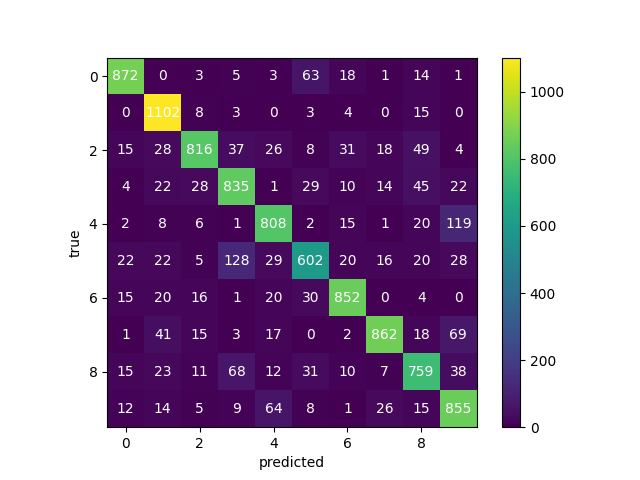

In [308]:
# plot the confusion matrix
nextplot()
M = sklearn.metrics.confusion_matrix(ytest, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()

0.9999999999822649
0.9999999996949782
0.9999999955447265
0.9999999478873192
0.999999302093004
0.9999908362580441
0.9998625944161882
0.9984220379937704
0.9859050917807745
0.8812574072789097


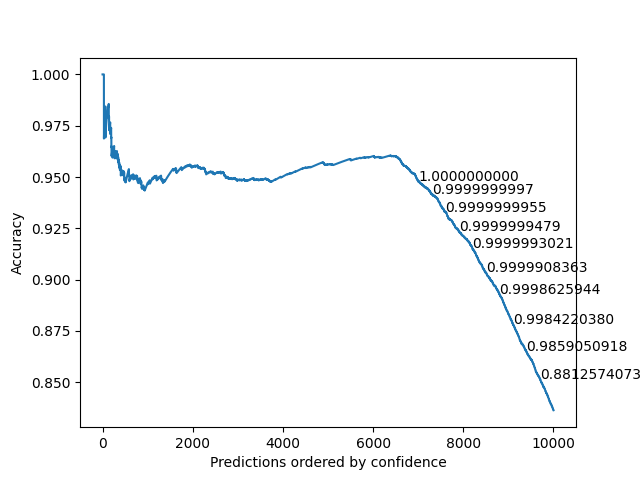

In [309]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(ytest[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot()
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))

Text(0, 0.5, 'Accuracy')

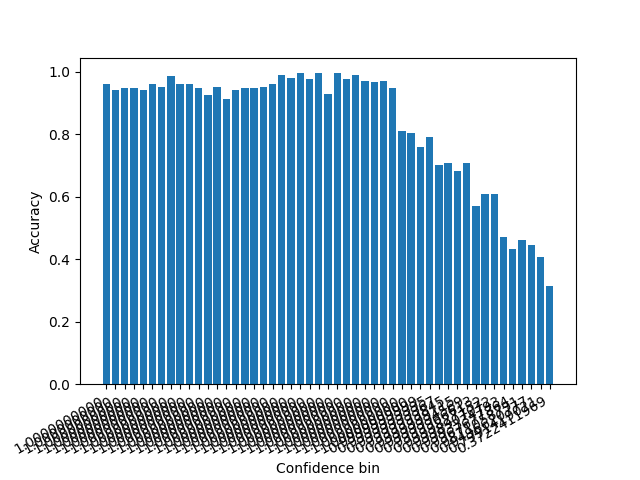

In [310]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 50) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(ytest[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
nextplot()
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)
plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

# 4 Model Selection (optional)

In [311]:
# To create folds, you can use:
K = 5
Kf = KFold(n_splits=K, shuffle=True)
for i_train, i_test in Kf.split(X):
    # code here is executed K times, once per test fold
    # i_train has the row indexes of X to be used for training
    # i_test has the row indexes of X to be used for testing
    print(
        "Fold has {:d} training points and {:d} test points".format(
            len(i_train), len(i_test)
        )
    )

Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points


In [312]:
# Use cross-validation to find a good value of alpha. Also plot the obtained
# accuracy estimate (estimated from CV, i.e., without touching test data) as a
# function of alpha.
# YOUR CODE HERE

# 5 Generating Data

In [313]:
def nb_generate(model, ygen):
    """Given a Naive Bayes model, generate some data.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    ygen : nd_array of shape (n,)
        Vector of class labels for which to generate data.

    Returns
    -------
    nd_array of shape (n,D)

    Generated data. The i-th row is a sampled data point for the i-th label in
    ygen.
    """
    logcls = model["logcls"]
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D))
    for i in range(n):
        c = ygen[i]
        # Generate the i-th example of class c, i.e., row Xgen[i,:]. To sample
        # from a categorical distribution with parameter theta (a probability
        # vector), you can use np.random.choice(range(K),p=theta).
        # YOUR CODE HERE

    return Xgen

Text(0.5, 0.98, 'Some generated digits for each class')

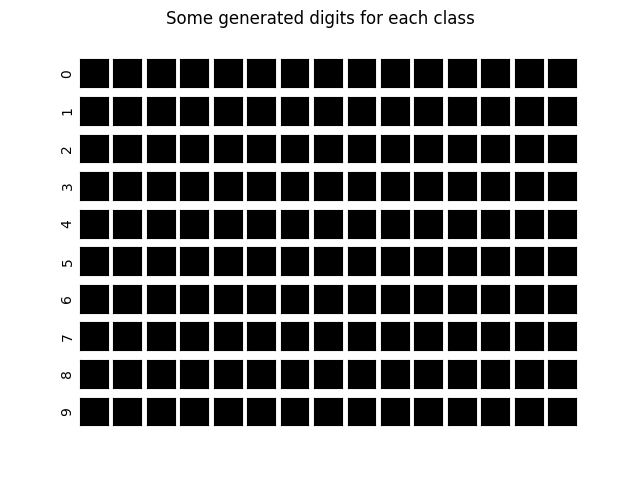

In [314]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb2, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

Text(0.5, 0.98, 'Most likely value of each feature per class')

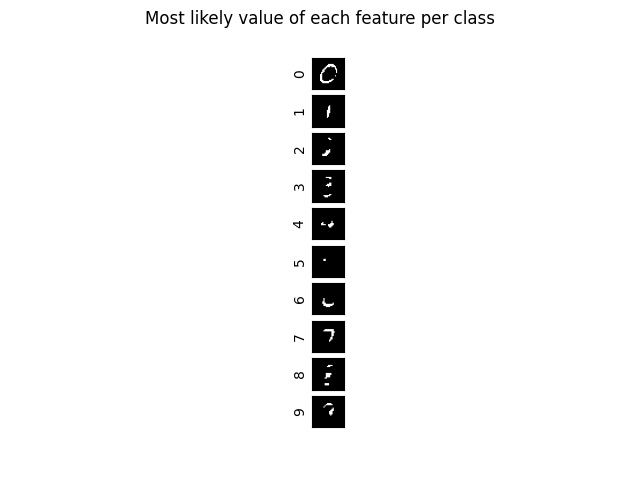

In [315]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb2["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

Text(0.5, 0.98, 'Expected value of each feature per class')

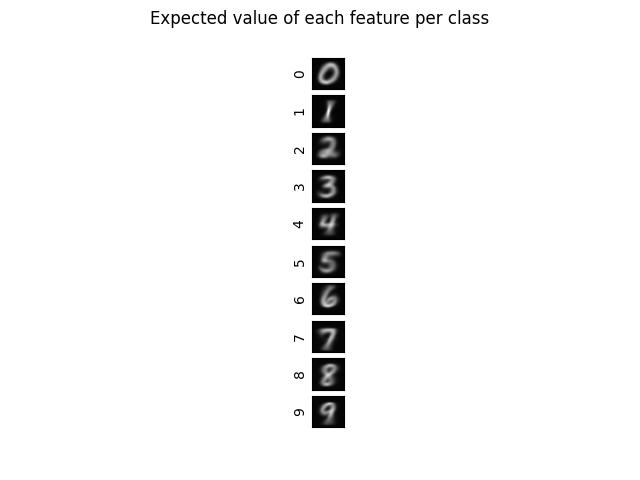

In [316]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb2["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")